In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRanker

# ------------------------------------------------------------------------------
# 1. 加载 & 预处理
# ------------------------------------------------------------------------------
df_trainers = pd.read_excel('New_User.xlsx')
df_behavior = pd.read_csv('user_behavior.csv')
df_filter   = pd.read_csv('user_filter.csv')

# 统一 ID 类型
df_trainers['trainer_id'] = df_trainers['trainer_id'].astype(str)
df_behavior['trainer_id'] = df_behavior['trainer_id'].astype(str)
df_behavior['user_id']    = df_behavior['user_id'].astype(str)
df_filter['user_id']      = df_filter['user_id'].astype(str)

trainer_ids = df_trainers['trainer_id'].values
user_ids    = df_filter['user_id'].values
n_trainers  = len(trainer_ids)
n_users     = len(user_ids)

# ------------------------------------------------------------------------------
# 2. 用户行为加权分 & 评分矩阵
# ------------------------------------------------------------------------------
w_click, w_watch, w_like = 0.3, 0.4, 0.3
df_behavior['score'] = (
    w_click * df_behavior['click'] +
    w_watch * df_behavior['watch'] +
    w_like * df_behavior['like']
)

rating_matrix = df_behavior.pivot_table(
    index='user_id', columns='trainer_id',
    values='score', fill_value=0
).reindex(index=user_ids, columns=trainer_ids, fill_value=0)
R = rating_matrix.values  # (n_users, n_trainers)

# ------------------------------------------------------------------------------
# 3. 内容分特征（标签匹配 + Final_Score）
# ------------------------------------------------------------------------------
df_trainers['specialities'] = df_trainers['specialities'].fillna('')
df_trainers['spec_list'] = df_trainers['specialities']\
    .apply(lambda x: [s.strip() for s in x.split(',') if s.strip()])
mlb = MultiLabelBinarizer()
T_spec = mlb.fit_transform(df_trainers['spec_list'])  # (n_trainers, n_specs)

df_filter['goal_list'] = df_filter['goal_list'].fillna('')
U_spec = MultiLabelBinarizer(classes=mlb.classes_)\
    .fit_transform(df_filter['goal_list']
                   .apply(lambda x: [s.strip() for s in x.split(',') if s.strip()]))

C1 = U_spec.dot(T_spec.T)
C1 = C1 / (C1.max(axis=1, keepdims=True) + 1e-9)

fs = df_trainers['Final_Score'].fillna(0).values.astype(float)
mn, mx = fs.min(), fs.max()
FS = (fs - mn) / (mx - mn + 1e-9) if mx > mn else fs * 0
C2 = np.tile(FS, (n_users, 1))

w_c1, w_c2 = 0.6, 0.4
C_raw = w_c1 * C1 + w_c2 * C2

# ------------------------------------------------------------------------------
# 4. 协同过滤分特征
# ------------------------------------------------------------------------------
sim = cosine_similarity(R.T)
mask = (R > 0).astype(float)
num = R.dot(sim)
den = mask.dot(sim) + 1e-9
CF_raw = num / den

# ------------------------------------------------------------------------------
# 5. 偏好分特征（价格偏好×0.2 缩放）
# ------------------------------------------------------------------------------
price_col = 'Pricing' if 'Pricing' in df_trainers.columns else 'price'
price_med = df_trainers[price_col].median()
alpha = 0.2
P_raw = np.ones((n_users, n_trainers))
for i, (_, row) in enumerate(df_filter.iterrows()):
    pref = row['filter_price']
    if pref == 'low to high':
        mask = (df_trainers[price_col].values < price_med).astype(float)
    elif pref == 'high to low':
        mask = (df_trainers[price_col].values > price_med).astype(float)
    else:
        mask = np.ones(n_trainers)
    P_raw[i] = alpha * mask

# ------------------------------------------------------------------------------
# 6. 全局 Min-Max 归一化
# ------------------------------------------------------------------------------
def minmax(arr):
    a_min, a_max = arr.min(), arr.max()
    return (arr - a_min) / (a_max - a_min + 1e-9)

C  = minmax(C_raw)
CF = minmax(CF_raw)
P  = minmax(P_raw)

# ------------------------------------------------------------------------------
# 7. 构建 LTR 特征表
# ------------------------------------------------------------------------------
user_idx    = np.repeat(np.arange(n_users), n_trainers)
trainer_idx = np.tile(np.arange(n_trainers), n_users)

feat = pd.DataFrame({
    'user_id':       user_ids[user_idx],
    'trainer_id':    trainer_ids[trainer_idx],
    'content_score': C.flatten(),
    'collab_score':  CF.flatten(),
    'pref_score':    P.flatten()
})

# 加入 linear_score 和交叉特征
feat['linear_score']  = 0.4*feat['content_score'] + 0.4*feat['collab_score'] + 0.2*feat['pref_score']
feat['cross_cf_pref'] = feat['collab_score'] * feat['pref_score']

# ------------------------------------------------------------------------------
# 8. 正负样本标注与采样
# ------------------------------------------------------------------------------
pos = df_behavior[['user_id','trainer_id']].copy()
pos['label'] = 1
feat = feat.merge(pos, on=['user_id','trainer_id'], how='left')
feat['label'] = feat['label'].fillna(0).astype(int)

pos_df = feat[feat['label']==1]
neg_df = feat[feat['label']==0].sample(frac=0.1, random_state=42)
df_ltr = pd.concat([pos_df, neg_df]).sample(frac=1, random_state=42)

# ------------------------------------------------------------------------------
# 9. 用户分组 train/test
# ------------------------------------------------------------------------------
users = df_ltr['user_id'].unique()
train_u, test_u = train_test_split(users, test_size=0.2, random_state=42)
train_mask = df_ltr['user_id'].isin(train_u)
test_mask  = df_ltr['user_id'].isin(test_u)

X = df_ltr[['content_score','collab_score','pref_score','linear_score','cross_cf_pref']].values
y = df_ltr['label'].values
X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]
group_train = df_ltr[train_mask].groupby('user_id').size().values
group_test  = df_ltr[test_mask].groupby('user_id').size().values

# ------------------------------------------------------------------------------
# 10. 训练 LGBMRanker（带正则与特征抽样）
# ------------------------------------------------------------------------------
ltr = LGBMRanker(
    n_estimators=200,
    max_depth=6,
    num_leaves=31,
    feature_fraction=0.8,
    lambda_l1=0.1,
    lambda_l2=0.1,
    random_state=42
)
ltr.fit(
    X_train, y_train,
    group=group_train,
    eval_set=[(X_test, y_test)],
    eval_group=[group_test],
    eval_at=[10],
    early_stopping_rounds=10,
    verbose=False
)

# ------------------------------------------------------------------------------
# 11. 生成并保存 LTR Top10 推荐
# ------------------------------------------------------------------------------
feat['ltr_score'] = ltr.predict(
    feat[['content_score','collab_score','pref_score','linear_score','cross_cf_pref']].values
)

top10 = (
    feat.sort_values(['user_id','ltr_score'], ascending=[True, False])
        .groupby('user_id').head(10)
        [['user_id','trainer_id','ltr_score']]
)
top10.to_csv('ltr_top10_with_pref_scaled.csv', index=False)

print("✅ LTR Top10 已输出到 ltr_top10_with_pref_scaled.csv")


c:\Users\91416\miniconda3\envs\FYP\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\91416\miniconda3\envs\FYP\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\91416\miniconda3\envs\FYP\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\91416\miniconda3\envs\FYP\lib\site-packages\sklearn\utils\d

✅ LTR Top10 已输出到 ltr_top10_with_pref_scaled.csv


In [15]:
import pandas as pd
import numpy as np

# 1. 读取推荐结果和用户行为数据（请修改为你的文件路径）
df_rec = pd.read_csv('ltr_top10_with_pref_scaled.csv')  # 改进版推荐结果
df_behavior = pd.read_csv('user_behavior.csv')          # 行为表，包含 user_id, trainer_id

# 2. 定义评估函数
def recall_precision_at_k(df_rec, df_behavior, k=10):
    true_dict = df_behavior.groupby('user_id')['trainer_id'].apply(set).to_dict()
    recalls, precisions = [], []
    for user, group in df_rec.groupby('user_id'):
        preds = set(group['trainer_id'].tolist()[:k])
        trues = true_dict.get(user, set())
        if not trues:
            continue
        hits = preds & trues
        recalls.append(len(hits) / len(trues))
        precisions.append(len(hits) / k)
    return np.mean(recalls), np.mean(precisions)

def ndcg_at_k(df_rec, df_behavior, k=10):
    true_dict = df_behavior.groupby('user_id')['trainer_id'].apply(set).to_dict()
    ndcgs = []
    for user, group in df_rec.groupby('user_id'):
        preds = group['trainer_id'].tolist()[:k]
        trues = true_dict.get(user, set())
        rel = [1 if pid in trues else 0 for pid in preds]
        dcg = sum(rel[i] / np.log2(i + 2) for i in range(len(rel)))
        ideal = sorted(rel, reverse=True)
        idcg = sum(ideal[i] / np.log2(i + 2) for i in range(len(ideal)))
        ndcgs.append(dcg / idcg if idcg > 0 else 0)
    return np.mean(ndcgs)

def mrr_at_k(df_rec, df_behavior, k=10):
    true_dict = df_behavior.groupby('user_id')['trainer_id'].apply(set).to_dict()
    mrrs = []
    for user, group in df_rec.groupby('user_id'):
        preds = group['trainer_id'].tolist()[:k]
        trues = true_dict.get(user, set())
        rr = 0
        for idx, pid in enumerate(preds):
            if pid in trues:
                rr = 1.0 / (idx + 1)
                break
        mrrs.append(rr)
    return np.mean(mrrs)

# 3. 计算并打印指标a
recall10, precision10 = recall_precision_at_k(df_rec, df_behavior, k=10)
ndcg10 = ndcg_at_k(df_rec, df_behavior, k=10)
mrr10 = mrr_at_k(df_rec, df_behavior, k=10)

print(f"Recall@10: {recall10:.4f}")
print(f"Precision@10: {precision10:.4f}")
print(f"NDCG@10: {ndcg10:.4f}")



Recall@10: 0.1732
Precision@10: 0.6046
NDCG@10: 0.9670


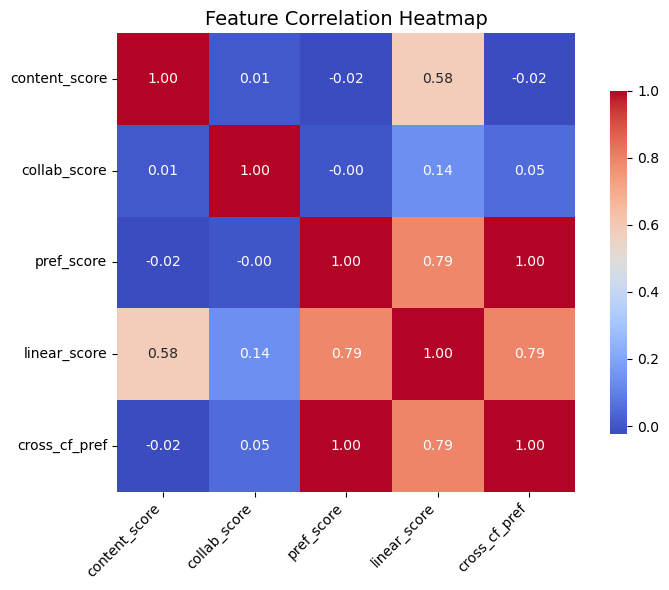

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# 如果你已经有 feat 表（LTR 特征表），选择数值型特征列
# 你可以根据你项目中的列名来替换下列字段
feature_cols = [
    'content_score', 'collab_score', 'pref_score', 'linear_score', 'cross_cf_pref'
    # 如果你有额外打分项比如 'retention_score', 'quality_score'，也可以加进来
]

# 只保留特征部分计算相关性
corr_matrix = feat[feature_cols].corr()

# 绘制热图
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,            # 显示数字
    fmt=".2f",             # 保留2位小数
    cmap='coolwarm',       # 颜色风格
    square=True,           # 单元格正方形
    cbar_kws={"shrink": .75}  # 缩小色条
)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("feature_correlation_heatmap.png", dpi=300)  # 可保存图片
plt.show()
